In [1]:
import numpy as np
import torch
import torch.nn as nn

import utils

from matplotlib import cm

from matplotlib import pyplot as plt

from mpc.track.src import simple_track_generator, track_functions

In [2]:
def plot_traj(x_sim):
    x_list = []
    y_list = []

    for i in range(x_sim.shape[0]):
        xy = utils.frenet_to_cartesian(x_sim[i,:2], track_coord)
        x_list.append(xy[0].numpy())
        y_list.append(xy[1].numpy())

    x_plot = np.array(x_list)
    y_plot = np.array(y_list)

    fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
    gen.plotPoints(ax)

    custom_cmap = plt.get_cmap('cubehelix').reversed()
    sct = ax.scatter(x_plot, y_plot, c=x_sim[:,4], cmap=custom_cmap, s=2)

    cbar = plt.colorbar(sct)
    cbar.set_label('Velocity') 

    print('x_init: ' + str(gen.xCoords[0]))
    print('y_init: ' + str(gen.yCoords[0]))
    print('yaw_init: ' + str(gen.tangentAngle[0]))
    print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
    plt.show()

In [3]:
class FrenetKinBicycleDx(nn.Module):
    def __init__(self, track_coordinates, params, dev):
        super().__init__()
        
        self.params = params

        # states: sigma, d, phi, v (4) + sigma_0, sigma_diff (2) + d_pen (1) + v_ub (1)
        self.n_state = 4+2+1+1
        print('Number of states:', self.n_state)
        
        self.n_ctrl = 2 # control: a, delta

        self.track_coordinates = track_coordinates.to(dev)

        # everything to calculate curvature
        self.track_sigma = self.track_coordinates[2,:]
        self.track_curv = self.track_coordinates[4,:]

        self.track_curv_shift = torch.empty(self.track_curv.size()).to(dev)
        self.track_curv_shift[1:] = self.track_curv[0:-1]
        self.track_curv_shift[0] = self.track_curv[-1]
        self.track_curv_diff = self.track_curv - self.track_curv_shift

        self.mask = torch.where(torch.absolute(self.track_curv_diff) < 0.1, False, True)
        self.sigma_f = self.track_sigma[self.mask]
        self.curv_f = self.track_curv_diff[self.mask]
     
        self.l_r = params[0]
        self.l_f = params[1]
        
        self.track_width = params[2]
        
        self.delta_threshold_rad = np.pi
        self.dt = params[3]

        self.smooth_curve = params[4]
        
        self.v_max = params[5]
        
        self.delta_max = params[6]
        
        self.factor_pen = 1000.
                
        
        
    def curv(self, sigma):

        num_sf = self.sigma_f.size()
        num_s = sigma.size()

        sigma_f_mat = self.sigma_f.repeat(num_s[0],1)

        sigma_shifted = sigma.reshape(-1,1) - sigma_f_mat
        curv_unscaled = torch.sigmoid(self.smooth_curve*sigma_shifted)
        curv = (curv_unscaled@(self.curv_f.reshape(-1,1))).type(torch.float)

        return curv.reshape(-1)
    
    
    def penalty_d(self, d):  
        overshoot_pos = (d - 0.35*self.track_width).clamp(min=0)
        overshoot_neg = (-d - 0.35*self.track_width).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_v(self, v):          
        overshoot_pos = (v - self.v_max).clamp(min=0)
        overshoot_neg = (-v + 0.001).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_delta(self, delta):          
        overshoot_pos = (delta - self.delta_max).clamp(min=0)
        overshoot_neg = (-delta - self.delta_max).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def forward(self, state, u):
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()


        a, delta = torch.unbind(u, dim=1)

        sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
        
        beta = torch.atan(self.l_r/(self.l_r+self.l_f)*torch.tan(delta))       
        k = self.curv(sigma)

        #dsigma = v*(torch.cos(phi+beta)/(1.-k*d))
        #dd = v*torch.sin(phi+beta)
        #dphi = v/(self.l_r+self.l_f)*torch.sin(beta)-k*v*(torch.cos(phi+beta)/(1-k*d))             
        #dv = a      
        
        #dsigma = v * torch.cos(phi) / (1 - d * k)
        #dd = v * torch.sin(phi)
        #dphi = (v * torch.tan(delta)) / (self.l_r+self.l_f) - k * dsigma
        #dv = a
        
        dsigma = v * torch.cos(phi) / (1 - d * k)
        dd = v * torch.sin(phi)
        dphi = (v * torch.tan(delta)) / (self.l_r+self.l_f) - k * v * torch.cos(phi) / (1-k*d)
        dv = a
    

        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        v = v + self.dt * dv 
        
        sigma_diff = sigma - sigma_0 
                
        d_pen = self.penalty_d(d)        
        v_ub = self.penalty_v(v)

        state = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), 1)
        
        return state

In [4]:
# This is the old dynamic bicycle model (with acceleration as input and weird behaviour)

class FrenetDynBicycleDx_old(nn.Module):
    def __init__(self, track_coordinates, params, dev):
        super().__init__()

        # states: sigma, d, phi, r, v_x, v_y (6) + sigma_0, sigma_diff (2) + d_pen (1) + v_ub (1)
        self.n_state = 6+2+1+1
        print(self.n_state)          # here add amount of states plus amount of exact penalty terms
        # control: a, delta
        self.n_ctrl = 2

        self.track_coordinates = track_coordinates.to(dev)

        # everything to calculate curvature
        self.track_sigma = self.track_coordinates[2,:]
        self.track_curv = self.track_coordinates[4,:]

        self.track_curv_shift = torch.empty(self.track_curv.size())
        self.track_curv_shift[1:] = self.track_curv[0:-1]
        self.track_curv_shift[0] = self.track_curv[-1]
        self.track_curv_diff = self.track_curv - self.track_curv_shift

        self.mask = torch.where(torch.absolute(self.track_curv_diff) < 0.1, False, True)
        self.sigma_f = self.track_sigma[self.mask]
        self.curv_f = self.track_curv_diff[self.mask]

        self.params = params
        
        self.l_r = params[0]
        self.l_f = params[1]
        
        self.track_width = params[2]
        
        self.delta_threshold_rad = np.pi
        self.dt = params[3]

        self.smooth_curve = params[4]
        
        self.v_max = params[5]
        
        self.delta_max = params[6]
        
        self.factor_pen = 1000.


    def curv(self, sigma):

        num_sf = self.sigma_f.size()
        num_s = sigma.size()

        sigma_f_mat = self.sigma_f.repeat(num_s[0],1)

        sigma_shifted = sigma.reshape(-1,1) - sigma_f_mat
        curv_unscaled = torch.sigmoid(self.smooth_curve*sigma_shifted)
        curv = (curv_unscaled@(self.curv_f.reshape(-1,1))).type(torch.float)

        return curv.reshape(-1)
    
    
    def penalty_d(self, d):  
        overshoot_pos = (d - 0.35*self.track_width).clamp(min=0)
        overshoot_neg = (-d - 0.35*self.track_width).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_v(self, v):          
        overshoot_pos = (v - self.v_max).clamp(min=0)
        overshoot_neg = (-v + 0.001).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_delta(self, delta):          
        overshoot_pos = (delta - self.delta_max).clamp(min=0)
        overshoot_neg = (-delta - self.delta_max).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)

    def forward(self, state, u):
        softplus_op = torch.nn.Softplus(20)
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()

        l_r = self.l_r
        l_f = self.l_f

        a, delta = torch.unbind(u, dim=1)

        sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)

        m = 0.5
        g = 9.81
        mu = 0.85
        I_z = m*l_r*l_f # this should be an approximation

        B = 6.0
        C = 1.6
        D = 1.0
        
        # car params
        lr = 0.045
        lf = 0.056
        m = 0.200
        Iz = 0.0004

        # lateral force params
        Df = 0.43
        Cf = 1.4
        Bf = 8.0
        Dr = 0.6
        Cr = 1.7
        Br = 8.0
        
        a_f = torch.atan2((v_y + l_f*r),torch.abs(v_x))-delta
        a_r = torch.atan2((v_y - l_r*r),torch.abs(v_x))

        F_yf = -Df*torch.sin(Cf*torch.atan(Bf*a_f))
        F_yr = -Dr*torch.sin(Cr*torch.atan(Br*a_r))

        dsigma = (v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d)
        dd = v_x*torch.sin(phi)+v_y*torch.cos(phi)
        dphi = r-self.curv(sigma)*((v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d))
        dr = 1/I_z*(l_f*F_yf - l_r*F_yr)
        dv_x = a + r*v_y
        dv_y = 1/m*(F_yf*torch.cos(delta)+F_yr)-r*v_x
        
        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        r = r + self.dt * dr
        v_x = v_x + self.dt * dv_x
        v_y = v_y + self.dt * dv_y
        sigma_0 = sigma_0                   # we need to carry it on
        sigma_diff = sigma - sigma_0

        d_pen = self.penalty_d(d)

        v_ub = self.penalty_v(v_x)

        state = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), 1)

        return state

    def forward(self, state, u):
        softplus_op = torch.nn.Softplus(20)
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()

        lr = self.l_r
        lf = self.l_f

        tau, delta = torch.unbind(u, dim=1)

        sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
        
        # car params
        m = 0.181
        I_z = 0.000505

        # lateral force params
        Df=0.65
        Cf=1.5
        Bf=5.2
        Dr=1.0
        Cr=1.45
        Br=8.5

        # longitudinal force params
        Cm1=0.98028992
        Cm2=0.01814131

        # friction force params
        Cd0=0.08518052
        Cd1=0.01
        Cd2=0.02750696

        gamma=0.5
        
        a_f = (torch.atan2((- v_y - lf*r),torch.abs(v_x))+delta)
        a_r = (torch.atan2((-v_y + lr*r),torch.abs(v_x)))
        
        # forces on the wheels
        Fm = (Cm1 - Cm2 * v_x) * tau  # motor force
        Ffriction = v_x/torch.abs(v_x) * (-Cd0 - Cd1 * v_x - Cd2 * v_x * v_x)  # friction force

        F_xf = Fm * (1 - gamma)  # front wheel force, x component
        F_xr = Fm * gamma  # rear wheel force, x component

        F_yf = Df*torch.sin(Cf*torch.atan(Bf*a_f))
        F_yr = Dr*torch.sin(Cr*torch.atan(Br*a_r))
        
        # dynamics including apparent forces
        Fx = F_xr + F_xf * torch.cos(delta) - F_yf * torch.sin(delta) + m * v_y * r + Ffriction
        Fy = F_yr + F_xf * torch.sin(delta) + F_yf * torch.cos(delta) - m * v_x * r
        Mz = F_yf * lf * torch.cos(delta) + F_xf * lf * torch.sin(delta) - F_yr * lr


        dsigma = (v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d)
        dd = v_x*torch.sin(phi)+v_y*torch.cos(phi)
        dphi = r-self.curv(sigma)*((v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d))
        dr = 1/I_z*Mz
        dv_x = 1/m*Fx
        dv_y = 1/m*Fy
        
        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        r = r + self.dt * dr
        v_x = v_x + self.dt * dv_x
        v_y = v_y + self.dt * dv_y
        sigma_0 = sigma_0                   # we need to carry it on
        sigma_diff = sigma - sigma_0

        d_pen = self.penalty_d(d)

        v_ub = self.penalty_v(v_x)

        state = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), 1)

        return state
    
    def forward(self, state, u):
        softplus_op = torch.nn.Softplus(20)
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()

        lr = self.l_r
        lf = self.l_f

        tau, delta = torch.unbind(u, dim=1)

        sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
        
        # car params
        m = 0.200
        I_z = 0.0004

        # lateral force params
        Df = 0.43
        Cf = 1.4
        Bf = 8.0
        Dr = 0.6
        Cr = 1.7
        Br = 8.0

        # longitudinal force params
        Cm1 = 0.98028992
        Cm2 = 0.01814131
        Cd = 0.02750696
        Croll = 0.08518052
        
        a_f = -(torch.atan2((- v_y - lf*r),torch.abs(v_x))+delta)
        a_r = -(torch.atan2((-v_y + lr*r),torch.abs(v_x)))

        
        # forces on the wheels
        F_x = (Cm1 - Cm2 * v_x) * tau - Cd * v_x * v_x - Croll  # motor force

        F_f = -Df*torch.sin(Cf*torch.atan(Bf*a_f))
        F_r = -Dr*torch.sin(Cr*torch.atan(Br*a_r))      


        dsigma = (v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d)
        dd = v_x*torch.sin(phi)+v_y*torch.cos(phi)
        dphi = r-self.curv(sigma)*((v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d))
        dr = 1/I_z*(F_f * lf * torch.cos(delta) - F_r * lr)
        dv_x = 1/m*(F_x - F_f * torch.sin(delta) + m * v_y * r)
        dv_y = 1/m*(F_r + F_f * torch.cos(delta) - m * v_x * r)
        
        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        r = r + self.dt * dr
        v_x = v_x + self.dt * dv_x
        v_y = v_y + self.dt * dv_y
        sigma_0 = sigma_0                   # we need to carry it on
        sigma_diff = sigma - sigma_0

        d_pen = self.penalty_d(d)

        v_ub = self.penalty_v(v_x)

        state = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), 1)

        return state

In [5]:
# This is the new dynamic bicycle model (with torque as input)

class FrenetDynBicycleDx(nn.Module):
    def __init__(self, track_coordinates, params, dev):
        super().__init__()

        # states: sigma, d, phi, r, v_x, v_y (6) + sigma_0, sigma_diff (2) + d_pen (1) + v_ub (1)
        self.n_state = 6+2+1+1
        print(self.n_state)          # here add amount of states plus amount of exact penalty terms
        # control: a, delta
        self.n_ctrl = 2

        self.track_coordinates = track_coordinates.to(dev)

        # everything to calculate curvature
        self.track_sigma = self.track_coordinates[2,:]
        self.track_curv = self.track_coordinates[4,:]

        self.track_curv_shift = torch.empty(self.track_curv.size())
        self.track_curv_shift[1:] = self.track_curv[0:-1]
        self.track_curv_shift[0] = self.track_curv[-1]
        self.track_curv_diff = self.track_curv - self.track_curv_shift

        self.mask = torch.where(torch.absolute(self.track_curv_diff) < 0.1, False, True)
        self.sigma_f = self.track_sigma[self.mask]
        self.curv_f = self.track_curv_diff[self.mask]

        self.params = params
        
        self.l_r = params[0]
        self.l_f = params[1]
        
        self.track_width = params[2]
        
        self.delta_threshold_rad = np.pi
        self.dt = params[3]

        self.smooth_curve = params[4]
        
        self.v_max = params[5]
        
        self.delta_max = params[6]
        
        self.factor_pen = 1000.


    def curv(self, sigma):

        num_sf = self.sigma_f.size()
        num_s = sigma.size()

        sigma_f_mat = self.sigma_f.repeat(num_s[0],1)

        sigma_shifted = sigma.reshape(-1,1) - sigma_f_mat
        curv_unscaled = torch.sigmoid(self.smooth_curve*sigma_shifted)
        curv = (curv_unscaled@(self.curv_f.reshape(-1,1))).type(torch.float)

        return curv.reshape(-1)
    
    
    def penalty_d(self, d):  
        overshoot_pos = (d - 0.35*self.track_width).clamp(min=0)
        overshoot_neg = (-d - 0.35*self.track_width).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_v(self, v):          
        overshoot_pos = (v - self.v_max).clamp(min=0)
        overshoot_neg = (-v + 0.001).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def penalty_delta(self, delta):          
        overshoot_pos = (delta - self.delta_max).clamp(min=0)
        overshoot_neg = (-delta - self.delta_max).clamp(min=0)
        penalty_pos = torch.exp(overshoot_pos) - 1
        penalty_neg = torch.exp(overshoot_neg) - 1 
        return self.factor_pen*(penalty_pos + penalty_neg)
    
    def forward(self, state, u):
        softplus_op = torch.nn.Softplus(20)
        squeeze = state.ndimension() == 1
        if squeeze:
            state = state.unsqueeze(0)
            u = u.unsqueeze(0)
        if state.is_cuda and not self.params.is_cuda:
            self.params = self.params.cuda()

        lr = self.l_r
        lf = self.l_f

        tau, delta = torch.unbind(u, dim=1)

        sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
        
        # car params
        m = 0.200
        I_z = 0.0004

        # lateral force params
        Df = 0.43
        Cf = 1.4
        Bf = 8.0
        Dr = 0.6
        Cr = 1.7
        Br = 8.0

        # longitudinal force params
        Cm1 = 0.98028992
        Cm2 = 0.01814131
        Cd = 0.02750696
        Croll = 0.08518052
        
        a_f = -(torch.atan2((- v_y - lf*r),torch.abs(v_x))+delta)
        a_r = -(torch.atan2((-v_y + lr*r),torch.abs(v_x)))

        
        # forces on the wheels
        F_x = (Cm1 - Cm2 * v_x) * tau - Cd * v_x * v_x - Croll  # motor force

        F_f = -Df*torch.sin(Cf*torch.atan(Bf*a_f))
        F_r = -Dr*torch.sin(Cr*torch.atan(Br*a_r))      


        dsigma = (v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d)
        dd = v_x*torch.sin(phi)+v_y*torch.cos(phi)
        dphi = r-self.curv(sigma)*((v_x*torch.cos(phi)-v_y*torch.sin(phi))/(1.-self.curv(sigma)*d))
        dr = 1/I_z*(F_f * lf * torch.cos(delta) - F_r * lr)
        dv_x = 1/m*(F_x - F_f * torch.sin(delta) + m * v_y * r)
        dv_y = 1/m*(F_r + F_f * torch.cos(delta) - m * v_x * r)
        
        sigma = sigma + self.dt * dsigma
        d = d + self.dt * dd
        phi = phi + self.dt * dphi
        r = r + self.dt * dr
        v_x = v_x + self.dt * dv_x
        v_y = v_y + self.dt * dv_y
        sigma_0 = sigma_0                   # we need to carry it on
        sigma_diff = sigma - sigma_0

        d_pen = self.penalty_d(d)

        v_ub = self.penalty_v(v_x)

        state = torch.stack((sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub), 1)

        return state
    

In [6]:
# I changed from 100 to 5 to try.
k_curve = 50.

dt = 0.04

mpc_T = 20
mpc_H = 40

l_r = 0.03
l_f = 0.03

v_max = 2.0

delta_max = 0.6

a_max = 1.5

track_density = 300
track_width = 0.5
t_track = 0.3
init_track = [0,0,0]

max_p = 100 

params = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, mpc_T])

In [7]:
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'DEMO_TRACK'

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)

track_function(gen, t_track, init_track)
gen.populatePointsAndArcLength()
gen.centerTrack()
track_coord = torch.from_numpy(np.vstack(
    [gen.xCoords, 
     gen.yCoords, 
     gen.arcLength, 
     gen.tangentAngle, 
     gen.curvature]))

In [31]:
# Kinematic
true_dx = FrenetKinBicycleDx(track_coord, params, 'cpu')

Number of states: 8


In [32]:
# Kinematic
x0 = torch.tensor([0.99,-0.18,0.,1.0,0.,0.,0.,0.])
x0_2 = torch.tensor([0.99,0.15,0.,1.0,0.,0.,0.,0.])
u = torch.tensor([0.1,0.4])

In [33]:
# Kinematic
true_dx.forward(x0, u)

tensor([[ 1.0289, -0.1800,  0.2757,  1.0040,  0.0000,  1.0289,  5.0125,  0.0000]])

In [34]:
# Kinematic
N_sims = 30
x_sims = torch.zeros((N_sims, 8))
x = x0.clone()
x_sims[0] = x0
for s in range(N_sims-1):  
    x_next = true_dx.forward(x, u)[0]
    x_sims[s+1] = x_next
    x = x_next
    
x_sims2 = torch.zeros((N_sims, 8))
x = x0_2.clone()
x_sims2[0] = x0_2
for s in range(N_sims-1):  
    x_next = true_dx.forward(x, u)[0]
    x_sims2[s+1] = x_next
    x = x_next

In [35]:
# Dynamic
true_dx = FrenetDynBicycleDx(track_coord, params, 'cpu')

10


In [41]:
# Dynamic
x0 = torch.tensor([2.3,-0.1,0. ,0., 0.5, 0.0,2.30,0.,0.,0.])  #sigma, d, phi, r, v_x, v_y, sigma_0, sigma_diff, d_pen, v_ub
x0_2 = torch.tensor([0.99,-0.18,0. ,0., 0.1, 0.0,0.99,0.,0.,0.])
u = torch.tensor([0.1,0.1])

In [42]:
# Dynamic
true_dx.forward(x0, u)

tensor([[ 2.3200e+00, -1.0000e-01, -1.5895e-09,  1.0400e+00,  4.9406e-01,
          6.9336e-02,  2.3000e+00,  2.0000e-02,  0.0000e+00,  0.0000e+00]])

In [43]:
# Dynamic
N_sims = 60
x_sims = torch.zeros((N_sims, 10))
x = x0.clone()
x_sims[0] = x0
for s in range(N_sims-1):  
    x_next = true_dx.forward(x, u)[0]
    x_sims[s+1] = x_next
    x = x_next
    
x_sims2 = torch.zeros((N_sims, 10))
x = x0_2.clone()
x_sims2[0] = x0_2
for s in range(N_sims-1):  
    x_next = true_dx.forward(x, u)[0]
    x_sims2[s+1] = x_next
    x = x_next

In [44]:
print(x_sims)

tensor([[ 2.3000e+00, -1.0000e-01,  0.0000e+00,  0.0000e+00,  5.0000e-01,
          0.0000e+00,  2.3000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.3200e+00, -1.0000e-01, -1.5895e-09,  1.0400e+00,  4.9406e-01,
          6.9336e-02,  2.3000e+00,  2.0000e-02,  0.0000e+00,  0.0000e+00],
        [ 2.3398e+00, -9.7227e-02,  4.1602e-02,  1.4486e+00,  5.0497e-01,
         -1.1764e-01,  2.3000e+00,  3.9762e-02,  0.0000e+00,  0.0000e+00],
        [ 2.3601e+00, -1.0109e-01,  9.9546e-02,  1.1074e+00,  4.9056e-01,
          4.6907e-02,  2.3000e+00,  6.0139e-02,  0.0000e+00,  0.0000e+00],
        [ 2.3795e+00, -9.7271e-02,  1.4384e-01,  9.9315e-01,  4.9886e-01,
         -6.9938e-02,  2.3000e+00,  7.9478e-02,  0.0000e+00,  0.0000e+00],
        [ 2.3996e+00, -9.7179e-02,  1.8357e-01,  4.6317e-01,  4.8872e-01,
          1.1258e-01,  2.3000e+00,  9.9627e-02,  0.0000e+00,  0.0000e+00],
        [ 2.4180e+00, -8.9183e-02,  2.0210e-01,  1.0293e+00,  5.0001e-01,
         -9.6144e-02,  2.3000e+0

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


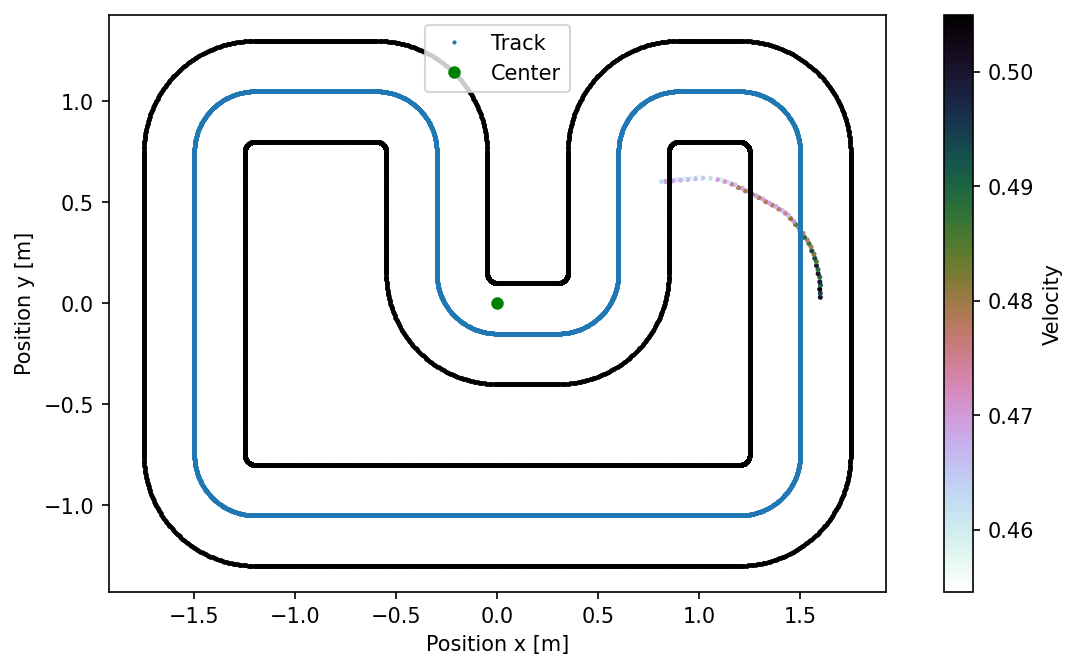

In [45]:
plot_traj(x_sims)

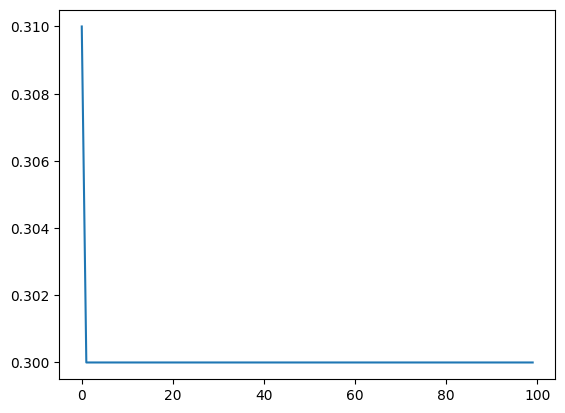

In [470]:
#plt.plot(u_sims[:,0])
plt.plot(u_sims[:,1])

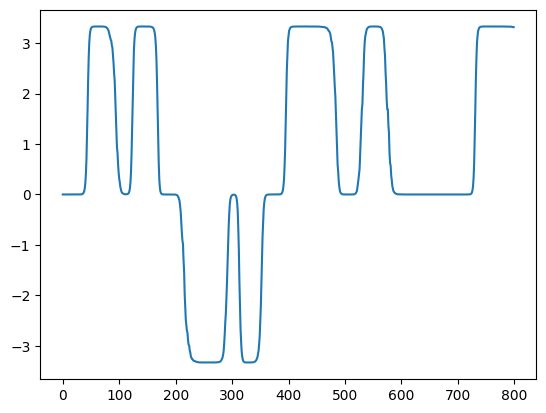

In [438]:
plt.plot(true_dx.curv(x_sims[:,0]))

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


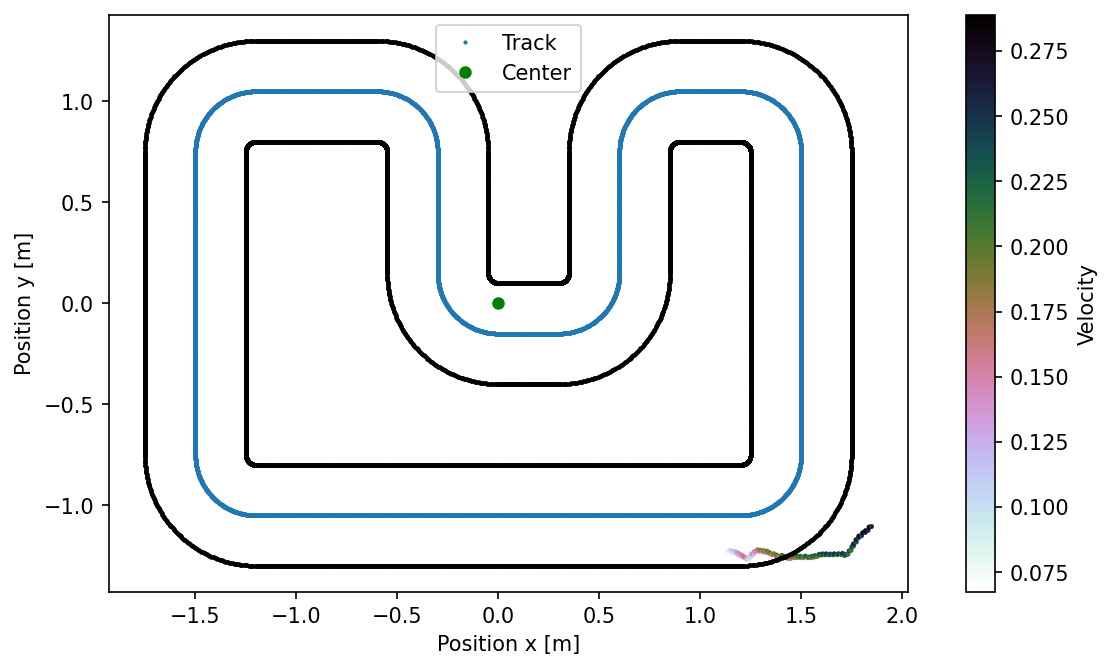

In [148]:
plot_traj(x_sims2)